In [1]:
using Knet,Compat,Plots;
include("../julia/test_train_split.jl");

In [16]:
# file, training_proportion, num_input_stops, stops_ahead_to_predict, stops_to_predict
# routes = get_routes("/Users/Cooper/Desktop/mbta_trajectories_2014_13.json",0.6,9,0,1,[],false);
path = "/Volumes/Infinity/mbta/h5/2015/"
key = "json"
files = map(x->string(path,x),filter(x->contains(x,key), readdir(path)))
routes = get_routes(files,0.8,7,0,1,[],true);
println(size(routes["train_input_data"]))
println(size(routes["train_output_data"]))
println(size(routes["test_input_data"]))
println(size(routes["test_output_data"]))

x_train  = routes["train_input_data"];
y_train = routes["train_output_data"];
x_test = routes["test_input_data"];
y_test = routes["test_output_data"];

(7, 4575)
(1, 4575)
(7, 1144)
(1, 1144)


In [8]:
function mlp(w,x)
    for i=1:2:length(w)
        # w is a vector of weight matrices
        x = w[i]*x .+ w[i+1]
        if i<length(w)-1
            # Apply ReLU nonlinearity
            x = max.(0,x)
        end
    end
    return x
end

loss(w,x,y)=0.5*(sum((y-mlp(w,x)).^2) / size(x,2))

mlplossgradient = grad(loss);

function train(w, dtrn; lr=.5, epochs=10, grad=lossgradient)
    for epoch=1:epochs
        for (x,y) in dtrn
            g = grad(w, x, y)
            Knet.update!(w,g,repmat([Sgd(lr=lr)],length(w)))
        end
    end
    return w
end

function weights(h)
    w = Any[]
    x = size(x_train)[1]
    for y in vcat(h,size(y_train)[1])
        push!(w,0.1*randn(y,x))
        push!(w, zeros(y, 1))
        x = y
    end
    return w
end


function mse(w, dtst; pred=mlp)
    s = 0
    n = 0
    for (x, ygold) in dtst
        ypred = pred(w, x)
        s+= (ypred - ygold).^2
        n+=1
    end
    return sqrt.(s/n)
    #return (sqrt.(s/n),1-(s/s_tot))
end

mse (generic function with 1 method)

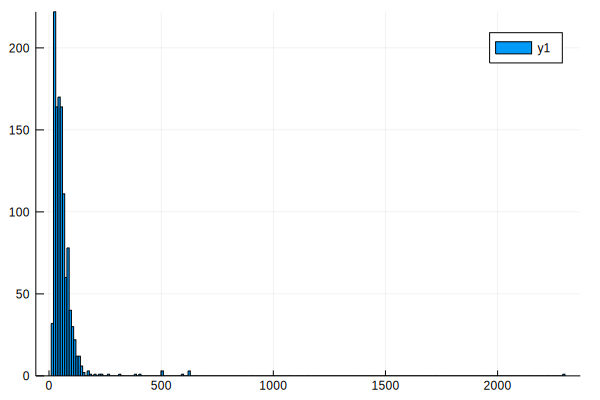

In [28]:
function main()
    hidden_layer_sizes = [15,10]
    w = weights(hidden_layer_sizes)
    println(size(w))
    dtrn = zip([x_train[:,i] for i in 1:size(x_train,2)],y_train)
    dtst = zip([x_test[:,i] for i in 1:size(x_test,2)],y_test)
    epochs = 25
    learning_rate = 0.0001
    train_losses = []
    test_losses = []
    train_loss = mse(w,dtrn)
    test_loss = mse(w,dtst)
    println((0,"Train MAE: ",train_loss[1],"Test MAE: ",test_loss[1]))
    push!(train_losses,train_loss[1])
    push!(test_losses,test_loss[1])
    @time for epoch=1:epochs
        train(w, dtrn; lr=learning_rate, epochs=1, grad=mlplossgradient)
        train_loss = mse(w,dtrn)
        test_loss = mse(w,dtst)
        println((epoch,"Train MAE: ",train_loss[1],"Test MAE: ",test_loss[1]))
        push!(train_losses,train_loss[1])
        push!(test_losses,test_loss[1])
#       gradcheck(loss, w, first(dtrn)...; gcheck=o[:gcheck], verbose=true)
    end
    return train_losses,test_losses
end

train_losses,test_losses = main();


(6,)
(0, "Train MAE: ", 85.39912757648995, "Test MAE: ", 104.14285090925169)
(1, "Train MAE: ", 60.29085708460612, "Test MAE: ", 85.34102301894865)


LoadError: [91mInterruptException:[39m

In [ ]:
plot(1:length(train_losses),[train_losses,test_losses],xlabel="Epoch",ylabel="Root mean square error (s)",title="Training and Test loss for Linear Model",label=["Train loss" "Test loss"],lw=3)
png(string("linear_",Dates.now()))

In [ ]:
# Plot the trajectory
@manipulate for i = 1:10
plot(cumsum(x_train[:,i]))
end

In [ ]:
function cnn(w,x)
  x = reshape(x,(length(x),1,1,1))
  n = length(w)-4
  for i=1:2:n
    x = pool(max.(0, conv4(w[i],x) .+ w[i+1]))
  end
  x = mat(x)
  for i=n+1:2:length(w)-2
    x = max.(0, w[i] * x .+ w[i+1])
  end
  return w[end-1] * x .+ w[end]
end

loss(w,x,y)=0.5*(sum((y-cnn(w,x)).^2) / size(x,2))
cnnlossgradient = grad(loss);
function wcnn(n)
    #size of filter, 1, number input filters, number filters
    wcnn=map(Array{Float64}, [ 0.1*randn(5,1,1,20),  zeros(1,1,20,1), 
                               0.1*randn(5,1,20,5), zeros(1,1,5,1),
                               0.1*randn(50,275),  zeros(50,1),
                               0.1*randn(n,50),  zeros(n,1) ]);
end
#cnn(w,x_train[:,1])

In [ ]:
function main()
    w = wcnn(size(y_train)[1])
    dtrn = zip([x_train[:,i] for i in 1:size(x_train,2)],y_train)
    dtst = zip([x_test[:,i] for i in 1:size(x_test,2)],y_test)
    epochs = 10
    learning_rate = 0.0001
    train_losses = []
    test_losses = []
    train_loss = mse(w,dtrn;pred=cnn)
    test_loss = mse(w,dtst;pred=cnn)
    println((0,"Train MAE: ",train_loss[1],"Test MAE: ",test_loss[1]))
    push!(train_losses,train_loss[1])
    push!(test_losses,test_loss[1])
    @time for epoch=1:epochs
        train(w, dtrn; lr=learning_rate, epochs=1, grad=cnnlossgradient)
        train_loss = mse(w,dtrn;pred=cnn)
        test_loss = mse(w,dtst;pred=cnn)
        println((epoch,"Train MAE: ",train_loss[1],"Test MAE: ",test_loss[1]))
        push!(train_losses,train_loss[1])
        push!(test_losses,test_loss[1])
    end
    return train_losses,test_losses
end

train_losses,test_losses = main();

In [ ]:

plot(1:length(train_losses),[train_losses,test_losses],xlabel="Epoch",ylabel="Root mean square error (s)",title="Training and Test loss for CNN",label=["Train loss" "Test loss"],lw=3)
png(string("cnn_",Dates.now()))

In [ ]:
# https://arxiv.org/pdf/1407.5949.pdf
function lstm(weight,bias,hidden,cell,input)
    gates   = hcat(input,hidden) * weight .+ bias
    hsize   = size(hidden,2)
    forget  = sigm(gates[:,1:hsize])
    ingate  = sigm(gates[:,1+hsize:2hsize])
    outgate = sigm(gates[:,1+2hsize:3hsize])
    change  = tanh(gates[:,1+3hsize:end])
    cell    = cell .* forget + ingate .* change
    hidden  = outgate .* tanh(cell)
    return (hidden,cell)
end

function initmodel(atype, hidden, vocab, embed)
    init(d...)=atype(xavier(d...))
    bias(d...)=atype(zeros(d...))
    model = Array(Any, 2*length(hidden)+3)
    X = embed
    for k = 1:length(hidden)
        H = hidden[k]
        model[2k-1] = init(X+H, 4H)
        model[2k] = bias(1, 4H)
        model[2k][1:H] = 1 # forget gate bias = 1
        X = H
    end
    model[end-2] = init(vocab,embed)
    model[end-1] = init(hidden[end],vocab)
    model[end] = bias(1,vocab)
    return model
end

let blank = nothing; global initstate
function initstate(model, batch)
    nlayers = div(length(model)-3,2)
    state = Array(Any, 2*nlayers)
    for k = 1:nlayers
        bias = model[2k]
        hidden = div(length(bias),4)
        if typeof(blank)!=typeof(bias) || size(blank)!=(batch,hidden)
            blank = fill!(similar(bias, batch, hidden),0)
        end
        state[2k-1] = state[2k] = blank
    end
    return state
end
end

function rnn(model, state, input; pdrop=0)
    nlayers = div(length(model)-3,2)
    newstate = similar(state)
    for k = 1:nlayers
        input = dropout(input, pdrop)
        
        (newstate[2k-1],newstate[2k]) = lstm(model[2k-1],model[2k],state[2k-1],state[2k],input)
        input = newstate[2k-1]
    end
    return input,newstate
end

loss_rnn(w,x,y)=0.5*(sum((y-rnn(w,x)).^2) / size(x,2))
lossgradient = grad(loss);

In [ ]:
function rnn1(w,x,h)
    h = tanh.(w[1]*vcat(x,h) .+ w[2])
    y = w[3]*h .+ w[4]
    return (y,h)
end

function rnnpredict(w,x)
    h = zeros(10)
    for t in 1:length(x)
        prediction,h = rnn1(w,x[t],h)
    end
    return prediction
end

function rnn_total_loss(w, dtst)
    s = 0
    n = 0
    for (x, ygold) in dtst
        s+=rnnloss(w,x,ygold)
        n+=1
    end
    return sqrt.(s/n)
end
    
function rnnloss(w,x,y_gold)
    state = zeros(10)
    prediction = 0
    for t in 1:length(x)
        prediction,state = rnn1(w,x[t],state)
    end
    return (prediction - y_gold)[1]^2
end

function rnnweights(h,s)
    w = Any[]
    push!(w,0.1*randn(h,1+s))
    push!(w,zeros(h))
    push!(w,0.1*randn(1,10))
    push!(w,zeros(1))
    return w
end
rnnlossgradient = grad(rnnloss)


In [ ]:
#https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
function main()
    hidden_layer_sizes = [10,10]
    w =  rnnweights(10,10)
    h = zeros(10)
    dtrn = zip([x_train[:,i] for i in 1:size(x_train,2)],y_train)
    dtst = zip([x_test[:,i] for i in 1:size(x_test,2)],y_test)
    epochs = 50
    learning_rate = 0.0001
    train_losses = []
    test_losses = []
    train_loss = rnn_total_loss(w,dtrn)
    test_loss = rnn_total_loss(w,dtst)
    println((0,"Train MAE: ",train_loss[1],"Test MAE: ",test_loss[1]))
    push!(train_losses,train_loss[1])
    push!(test_losses,test_loss[1])
    @time for epoch=1:epochs
        train(w, dtrn; lr=learning_rate, epochs=1, grad=rnnlossgradient)
        train_loss = rnn_total_loss(w,dtrn)
        test_loss = rnn_total_loss(w,dtst)
        println((epoch,"Train MAE: ",train_loss[1],"Test MAE: ",test_loss[1]))
        push!(train_losses,train_loss[1])
        push!(test_losses,test_loss[1])
    end
    return train_losses,test_losses
end

train_losses,test_losses = main();

In [ ]:
plot(1:length(train_losses),[train_losses,test_losses],xlabel="Epoch",ylabel="Root mean square error (s)",title="Training and Test loss for RNN",label=["Train loss" "Test loss"],lw=3)
png(string("rnn_",Dates.now()))

In [3]:
x= ["Linear","MLP","CNN","RNN"]
y=[61,39.5,37,30.1]
b = bar(x,y,title="Root mean square error of models (lower is better)",xlabel="Model class",ylabel="Root mean square error (s)",color="#e67e22",alpha=0.4)
png("rmse_bar")

x= ["Linear","MLP","CNN","RNN"]
Rsquared=[0.636 , 0.8035 , 0.8264 , 0.8859]

b = bar(x,Rsquared,title="R squared score of models (higher is better)",xlabel="Model class",ylabel="R squared score",color="#e67e22",alpha=0.4)
png("r2_bar")

LoadError: [91mUndefVarError: R not defined[39m